<IPython.core.display.Latex object>

Good! File exists!


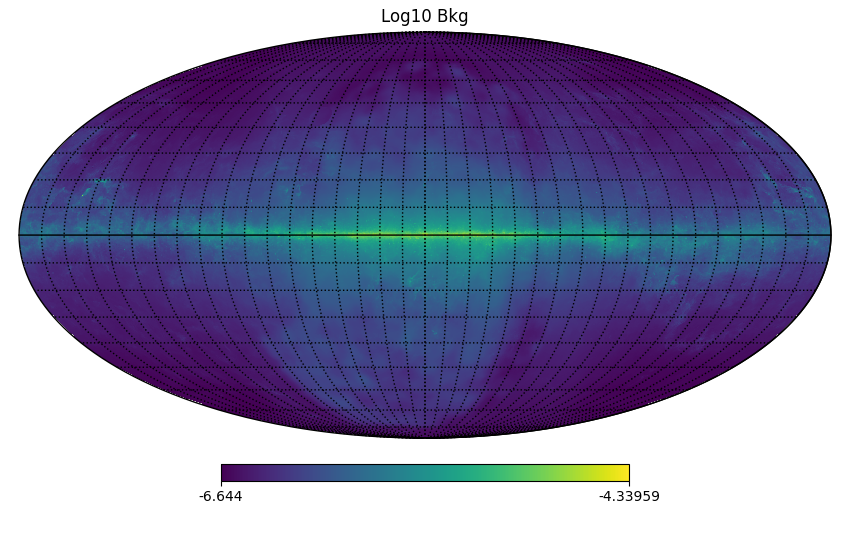

In [1]:
import sys
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import tqdm
from astropy.io import fits
#from firesong.Firesong import firesong_simulation
from multiprocessing import Pool
%matplotlib ipympl
from IPython.display import Latex,display
sys.path.append('../LHAASO_PSF/') 
import Plot
import PSF
import os
import time

#------------------------参数设置----------------------------------

xsize = 320 #卷积前的图像尺寸，每像素对应尺度为 2*radius/xsize, 这个值应当设置得较小。
radius = 3.2 #图像半径， 可以修改至6.4,这样最后出来的图宽度为128
pixelwidth = radius*2/xsize
display(Latex('Pixel Width: $%.2f ^ \\circ/\\mathrm{pixel}$'%pixelwidth))
nfigure = 8#28*1000 #生成多少张训练图像（有28个能量段）
singleE= True #只用第一个能量bin的背景模拟，节省时间，测试程序用。

def fdcenter(energy_idx):
    ra_center = np.array([])
    dec_center = np.array([])
    phi = 1.618
    for i in range(int(energy_idx.max())+1):
        num = np.argwhere(energy_idx == i).shape[0]
        n = np.arange(num)-int(num/2)
        dec_tmp = np.arcsin(2*n/num)*180/np.pi
        ra_tmp = np.mod(360 * n/phi +num*360,360)
        ra_center = np.hstack((ra_center,ra_tmp))
        dec_center = np.hstack((dec_center,dec_tmp))

    return ra_center,dec_center

if singleE:
    energy_idx = np.zeros(nfigure)
else:
    energy_idx = np.floor(np.arange(nfigure)/(nfigure-1+1e-10)*28)#每张图对应的能量索引

ra_center,dec_center = fdcenter(energy_idx)
#ra_center = np.mod(np.linspace(0,360*28,nfigure),360) #每张图像的中心坐标
#ec_center = np.mod(np.linspace(0,180*28,nfigure),180)-90

NPROC = 12 # 线程数
RANDOMPSF = False #是否将psf进行随机微调 
POINTSRC = 5 # 添加点源的最大数量每图

psfradius = 2. #尽量不要修改，这里为了节约计算量，忽略了大于该半径的psf作用效果。（PSF卷积核半径）

binsize = 0.1  #单位是度，必须大于卷积前像素的尺度
target_sig = 0.1
NSIDE = 2048  #初始分辨率

#-------------------------程序主体----------------------------------

#检查背景文件是否存在
'''
推荐直接上Fermi LAT 网站下载，放到/Simulation/ 目录
https://fermi.gsfc.nasa.gov/ssc/data/access/lat/BackgroundModels.html
'''
if os.path.exists('./gll_iem_v07.fits'):
    print('Good! File exists!')
else:
    print('File not found, start downloading.\n download is show, manual download is recommended. ')
    print('https://fermi.gsfc.nasa.gov/ssc/data/access/lat/BackgroundModels.html')
    start = input('Start download? y/n')
    if start == 'y':
        os.system('wget https://fermi.gsfc.nasa.gov/ssc/data/analysis/software/aux/4fgl/gll_iem_v07.fits')
    else: 
        raise ValueError('Download aborted.')
#galabkg = np.load('Fermi-LAT_pi0_map.npy')
#galabkg = hp.ud_grade(galabkg,NSIDE)
hdulist = fits.open('gll_iem_v07.fits')


data = hdulist[0].data[0,:,:]
galabkg = Plot.img2healpix(512,1024,data)


hp.mollview(np.log10(galabkg),rot = (180,0),title='Log10 Bkg')
hp.graticule(dpar = 10,dmer=10)

In [2]:

ROI = []
ROI_BLUR = []

def process(idx):
    #随机种子
    np.random.seed(int((time.time()-int(time.time()))*1e6))

    # 返回拟合的lhaaso psf以及目标的高斯psf
    #randompsf参数可以调节是否将psf进行随机微调
    psfconv = PSF.lhaaso_psf(4)

    # 按需加入点源
    if POINTSRC != 0:
        pointsrc = np.random.randint(POINTSRC)
    else:
        pointsrc = 0

    
    ra_c,dec_c,i = idx
    #------真实坐标不重要---------
    npixedge = int(psfradius/pixelwidth)+1
    x = np.linspace(-radius+pixelwidth,radius,xsize)
    y = np.linspace(-radius+pixelwidth,radius,xsize)


    #含有边界，边界上psf无法很好卷积，会出现异常值。这里先包括额外的边界，然后卷积，然后再删掉边界
    x_edge = np.linspace(-radius-psfradius+pixelwidth,radius+psfradius,xsize+2*npixedge)
    y_edge = np.linspace(-radius-psfradius+pixelwidth,radius+psfradius,xsize+2*npixedge)

    #----------------按照中心坐标和半径选取天区-----------------------

    
    roi = Plot.selectreg_interp(galabkg,ra_c,dec_c,radius+psfradius,NSIDE,xsize=xsize+2*npixedge,plot = False)

    if pointsrc != 0 :
        for niter in range(pointsrc):
            ix_src = int(np.random.randint(int(xsize*0.8)) + npixedge)
            iy_src = int(np.random.randint(int(xsize*0.8)) + npixedge)
            roi[ix_src+int(xsize*0.1),iy_src+int(xsize*0.1)] += roi.max()*np.random.uniform(10,20)

    roi_rebin,xx,yy  = PSF.bindata(roi,x_edge,y_edge,binsize)
    del(roi)
    
    x_rebin = xx[0,:]
    y_rebin = yy[:,0]
    hpix = int(radius/binsize)
    cpix = int(x_rebin.shape[0]/2)
    
    
    #print(roi.shape)
    #------------对图像逐一卷积，如果卷积前分辨率很高，耗时会很长。--------------------
    #使用了scipy.signal.convolve2d来卷积
    # 卷积PSF
    roi_blur,psf_tuple = psfconv(roi_rebin,x_rebin,y_rebin,psfradius=psfradius,returnPSF = True)
    roi_blur = roi_blur[cpix-hpix:cpix+hpix,cpix-hpix:cpix+hpix]

    # 不卷积PSF作为原图
    roi = roi_rebin[cpix-hpix:cpix+hpix,cpix-hpix:cpix+hpix]
    
    return (roi,roi_blur,psf_tuple)
    #ROI.append(roi_rebin)
    #ROI_BLUR.append(blur_rebin)


res = []

print('begin MP: simulating, total energy:28')
t_begin = time.time()

# 开始并行卷积
for eidx in range(int(energy_idx.max())+1): 
    idx = []
    for i in range(nfigure):
        if energy_idx[i] == eidx:
            idx.append((ra_center[i],dec_center[i],i))
    if len(idx) == 0:
        continue

    data = hdulist[0].data[eidx,:,:]
    galabkg = Plot.img2healpix(512,1024,data)
        
    with Pool(NPROC) as pool:
        restmp=pool.map(process,idx)
    res.extend(restmp)
    print('finish energy %d, time used %.2f'%(eidx,time.time()-t_begin))

# 结果
res = np.array(res,dtype= object)

begin MP: simulating, total energy:28
finish energy 0, time used 7.08


/tmp/ipykernel_53742/823932707.py:5: RuntimeWarning: invalid value encountered in log10
  ax[a][0].imshow(np.log10(res[a][0]))


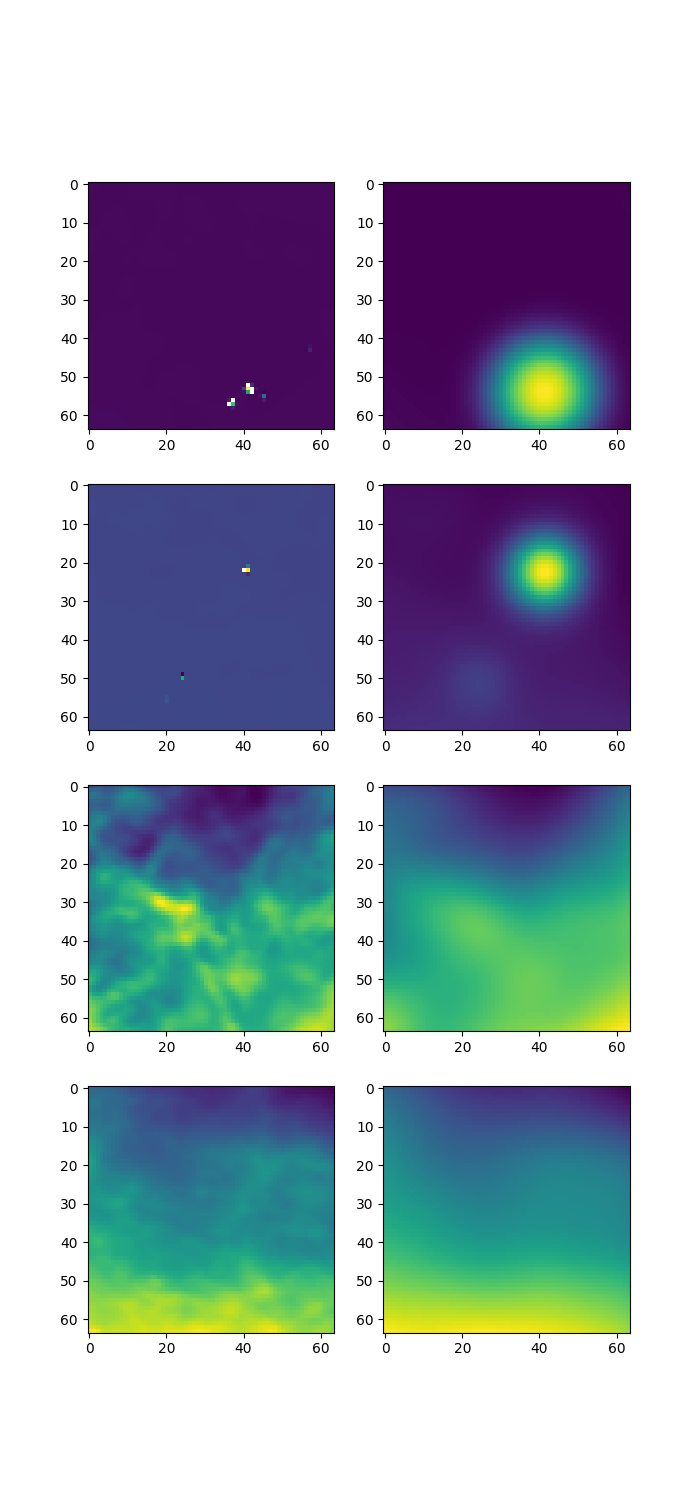

In [3]:
# 画几个图看看
a = 0
fig,ax = plt.subplots(4,2,figsize = (7,15))
for a in range(4):
    ax[a][0].imshow(np.log10(res[a][0]))
    ax[a][1].imshow(np.log10(res[a][1]))


In [4]:
if os.path.exists('../SimulatedData/')==False:
    os.system('mkdir ../SimulatedData')
# np.save('../SimulatedData/bkg_blur_orig.npy',res)
# 保存，结构如下
#res[i,0] -----original
#res[i,1] -----blur
#res[i,2] -----tuple (angle,psf(angle))
#np.save('../SimulatedData/blurred.npy',res[:,1,:,:])